# Import the Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the Image Training and Validation Datasets

In [2]:
train_dataset_path = '/kaggle/input/riceleafs/RiceLeafs/train'
validation_dataset_path = '/kaggle/input/riceleafs/RiceLeafs/validation'

In [3]:
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=target_size,  
    batch_size=16,  
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    target_size=target_size, 
    batch_size=16, 
    class_mode='categorical' 
)

Found 2684 images belonging to 4 classes.
Found 671 images belonging to 4 classes.


In [4]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : BrownSpot
1 : Healthy
2 : Hispa
3 : LeafBlast


# Plotting Sample Training Images

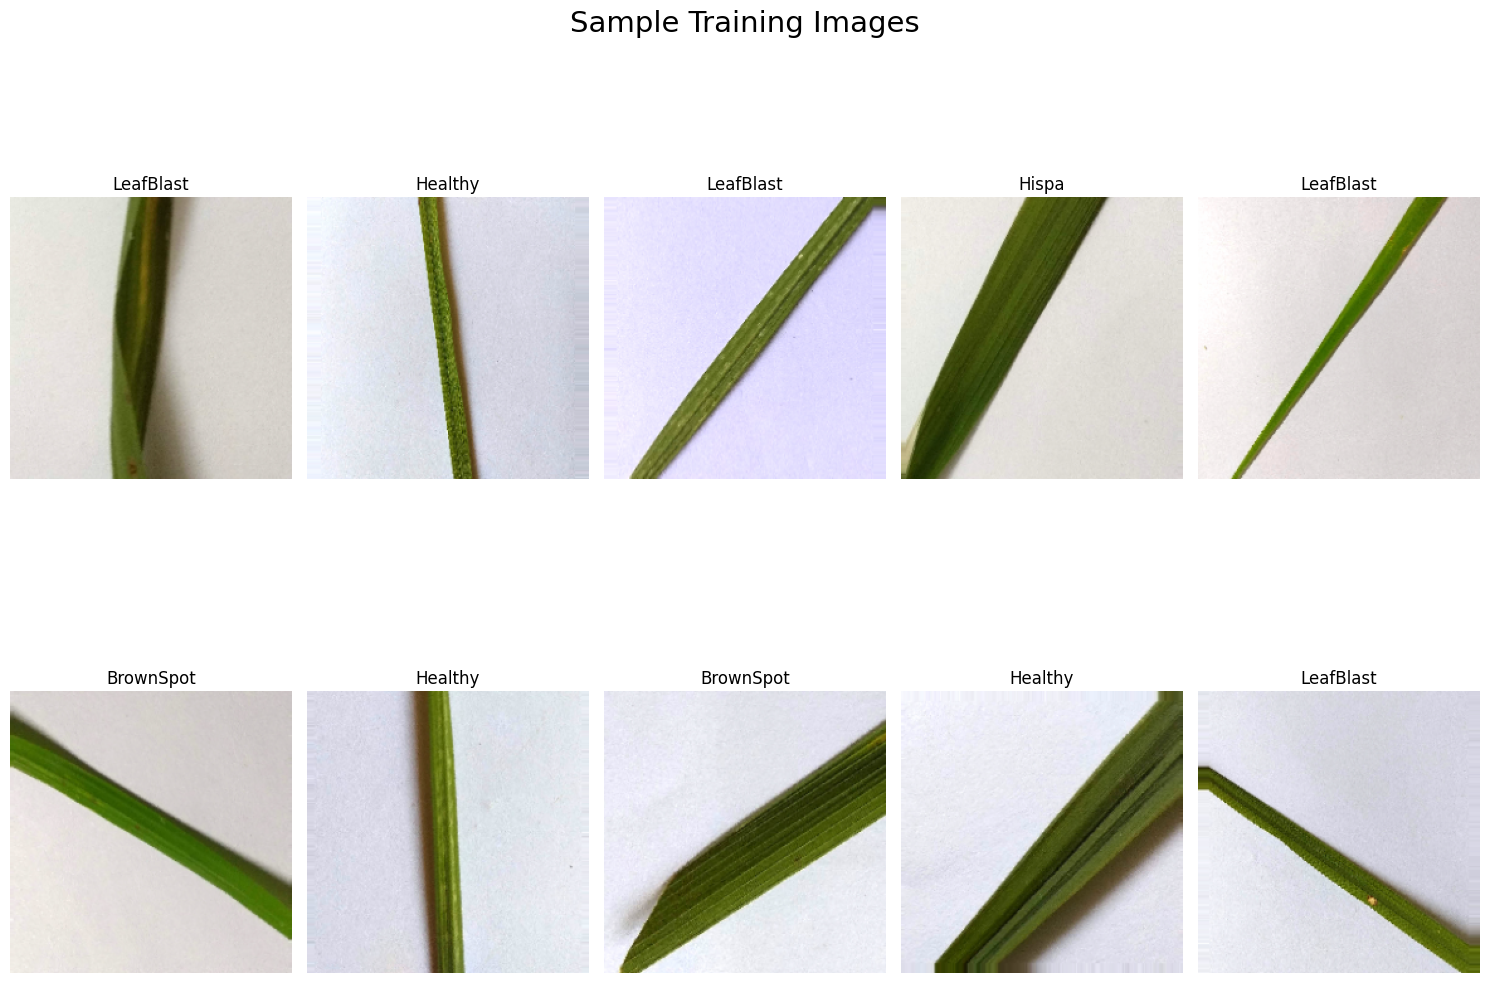

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Training a CNN Model

In [6]:
def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=16, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])
    
    return model

In [7]:
cnn_model = create_model()

print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,410,420 (5.38 MB)

 Trainable params: 1,410,196 (5.38 MB)

 Non-trainable params: 224 (896.00 B)

None


In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

optimizer = Adam(learning_rate=0.001)

cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50


I0000 00:00:1716794779.586707     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716794779.607449     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716795051.261098     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 - 354s - 2s/step - accuracy: 0.4396 - loss: 2.6077 - val_accuracy: 0.1833 - val_loss: 1.4426 - learning_rate: 0.0010
Epoch 2/50
168/168 - 214s - 1s/step - accuracy: 0.4825 - loss: 1.4451 - val_accuracy: 0.3949 - val_loss: 1.6845 - learning_rate: 0.0010
Epoch 3/50
168/168 - 216s - 1s/step - accuracy: 0.5425 - loss: 1.2103 - val_accuracy: 0.3845 - val_loss: 1.6212 - learning_rate: 0.0010
Epoch 4/50
168/168 - 216s - 1s/step - accuracy: 0.5645 - loss: 1.0848 - val_accuracy: 0.1207 - val_loss: 4.5416 - learning_rate: 0.0010
Epoch 5/50
168/168 - 216s - 1s/step - accuracy: 0.5682 - loss: 1.0861 - val_accuracy: 0.2012 - val_loss: 13.9319 - learning_rate: 0.0010
Epoch 6/50
168/168 - 216s - 1s/step - accuracy: 0.5745 - loss: 1.0617 - val_accuracy: 0.0954 - val_loss: 24.7251 - learning_rate: 0.0010
Epoch 7/50
168/168 - 215s - 1s/step - accuracy: 0.5991 - loss: 0.9743 - val_accuracy: 0.2534 - val_loss: 2.5263 - learning_rate: 3.1623e-04
Epoch 8/50
168/168 - 216s - 1s/step - accuracy: 0.611

# Plotting the Model Metrics

In [11]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

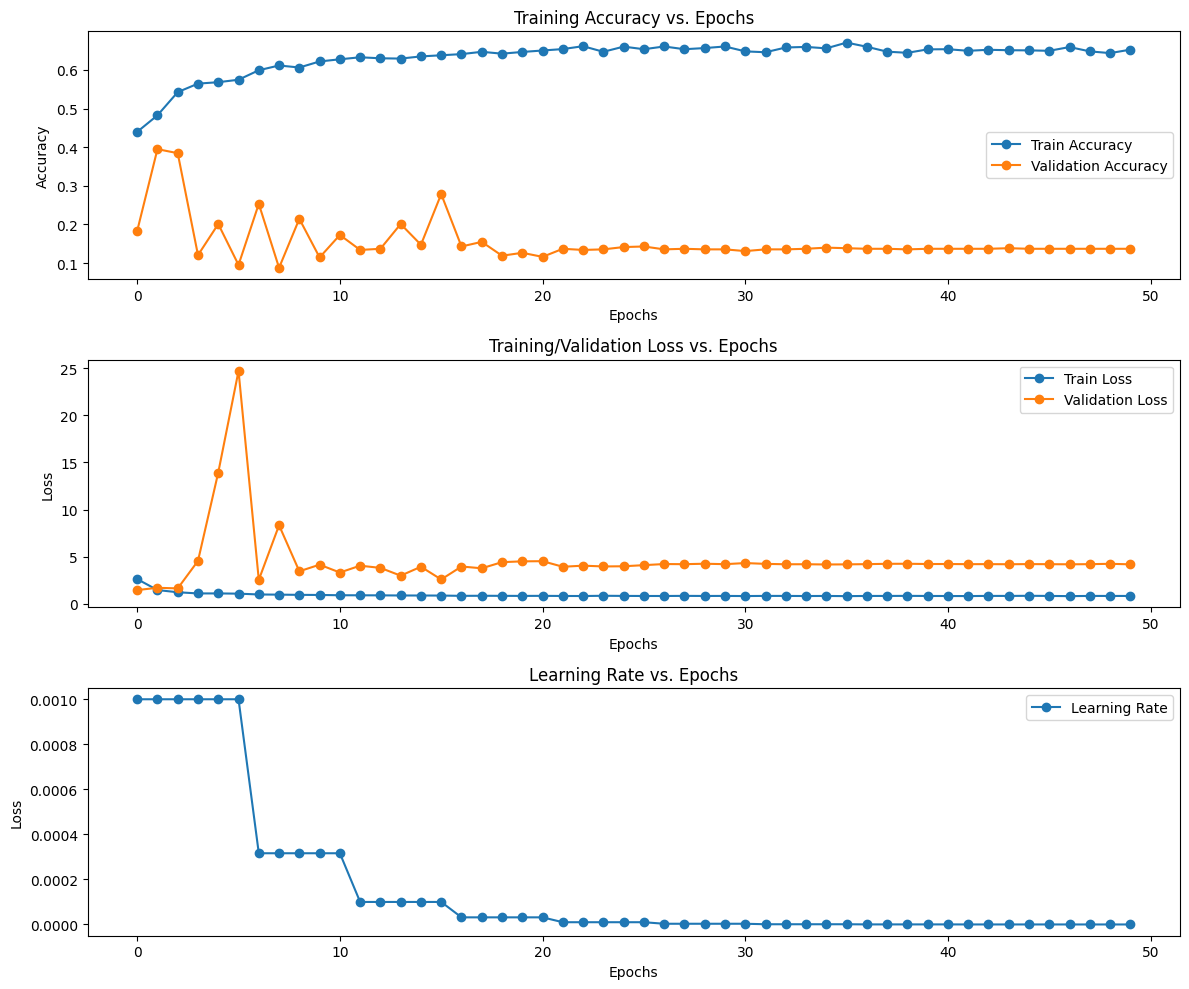

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# Testing the Model on Test Set

In [13]:
test_dataset = '/kaggle/input/riceleafs/RiceLeafs/validation'

In [16]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=16,
                                                 target_size = (224, 224),
                                                 class_mode='categorical')

Found 671 images belonging to 4 classes.


# Model Prediction on the Test Dataset

In [17]:
predictions = cnn_model.predict(test_generator)

 1/42 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step

W0000 00:00:1716805967.269129     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 822ms/step


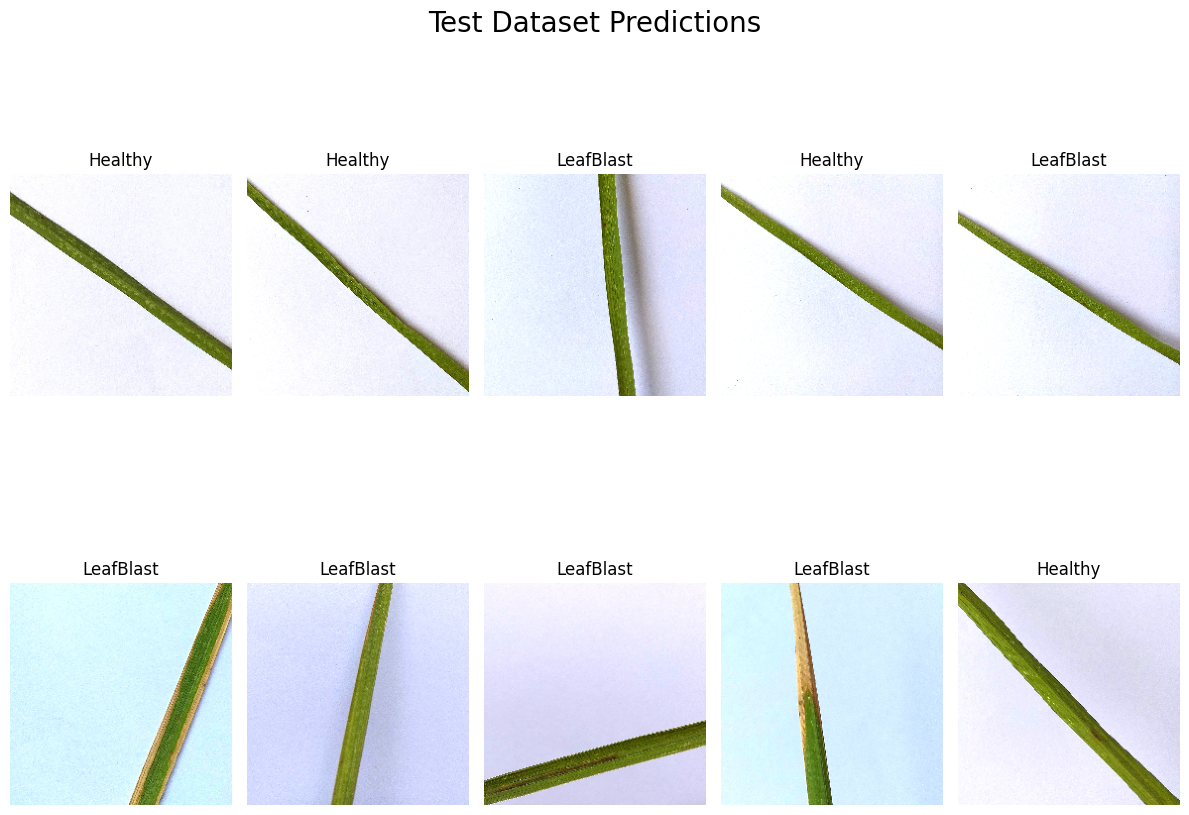

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [20]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=16)

42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 841ms/step - accuracy: 0.2008 - loss: 5.6087


In [21]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     4.1768083572387695
Test Accuracy: 0.13710878789424896


# Plotting the Classification Metrics

In [22]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

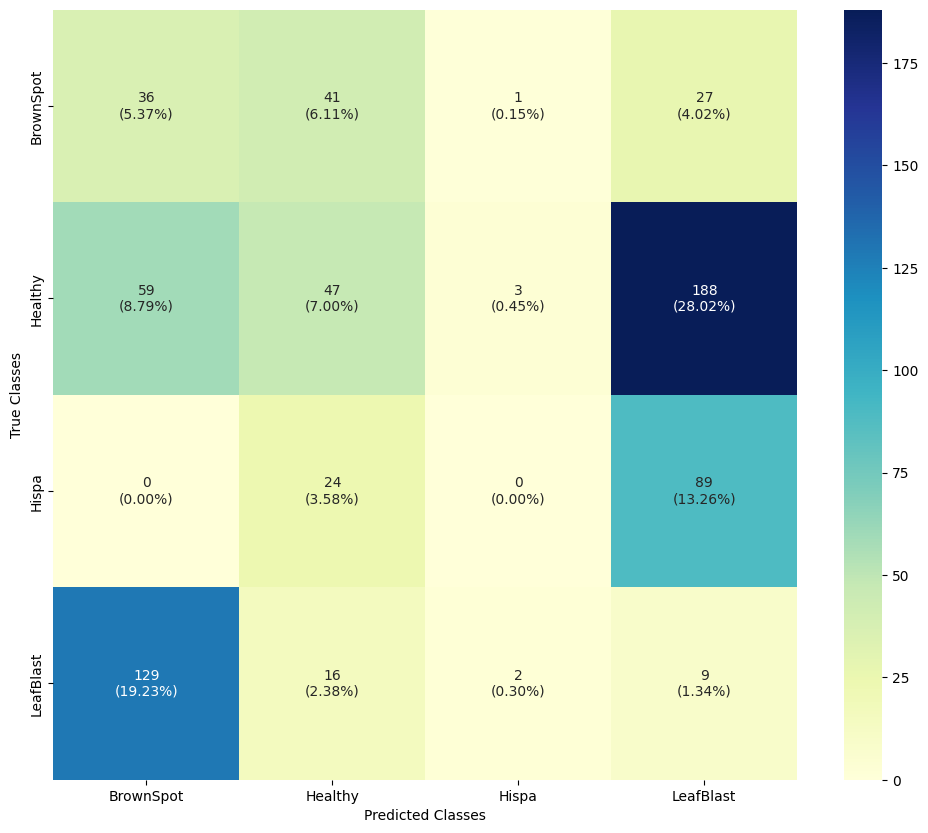

In [26]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [27]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   BrownSpot       0.16      0.34      0.22       105
     Healthy       0.37      0.16      0.22       297
       Hispa       0.00      0.00      0.00       113
   LeafBlast       0.03      0.06      0.04       156

    accuracy                           0.14       671
   macro avg       0.14      0.14      0.12       671
weighted avg       0.19      0.14      0.14       671



# Wrong Predictions

In [28]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [29]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

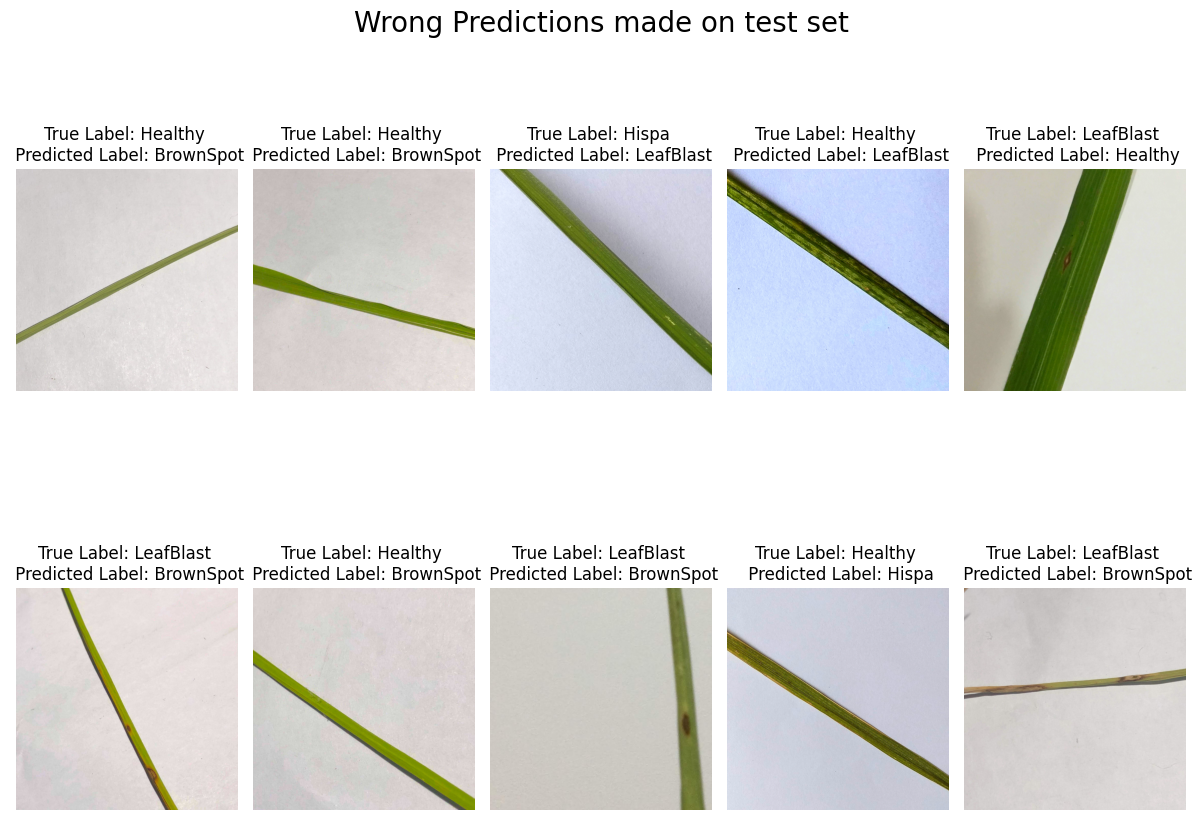

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()